# Pre-Process Fakeprints for Training

This notebook generates the fakeprints for the training dataset. It loads each audio file, resamples it to the model's sampling rate if necessary, and computes the fakeprints using the `get_fakeprints` function. The resulting fakeprints are saved as `.npz` files in the specified output directory.

In [1]:
import os
import torch
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..",".."))
os.chdir(project_root)

ai_dir = "src/checkpoints/fp/ai"
human_dir = "src/checkpoints/fp/human"

os.makedirs(os.path.join(project_root, ai_dir), exist_ok=True)
os.makedirs(os.path.join(project_root, human_dir), exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

N_FFT = 1 << 14  # 16384
SR = 48000
nyquist = SR / 2
F_MIN = 32.7  # C1 note frequency
BINS_PER_OCTAVE = 96
F_RANGE = [200, 6000]

Using device: cpu


## 1. Preprocess AI Generated Dataset

In [ ]:
import glob
from src.models.utils import preprocess_fakeprints

num_samples = 500

data_dir = "/path/to/datasets/suno_v5_500"

file_paths = glob.glob(f"{data_dir}/*.mp3")
file_paths = file_paths[:num_samples]

ai_fp = preprocess_fakeprints(
    file_paths,
    n_fft=N_FFT,
    sampling_rate=SR,
    bins_per_octave=BINS_PER_OCTAVE,
    freq_range=F_RANGE,
    device=DEVICE,
)

### Save Fakeprints

In [ ]:
np.savez(f"{ai_dir}/fakeprints_01.npz", **ai_fp)

## 2. Preprocess Human Dataset

In [ ]:
import glob
from src.models.utils import preprocess_fakeprints

num_samples = 500

data_dir = "/path/to/datasets/fma_small"

file_paths = glob.glob(f"{data_dir}/**/*.mp3", recursive=True)
file_paths = file_paths[:num_samples]

human_fp = preprocess_fakeprints(
    file_paths,
    n_fft=N_FFT,
    sampling_rate=SR,
    bins_per_octave=BINS_PER_OCTAVE,
    freq_range=F_RANGE,
    device=DEVICE,
)

### Save Fakeprints

In [ ]:
np.savez(f"{human_dir}/fakeprints_01.npz", **human_fp)

## 3. Load Fakeprints for Visualization

In [11]:
from src.models.utils import get_freqs

TRANSFORM = "cqt"
SHOW_AI_FP = True

dir_path = ai_dir if SHOW_AI_FP else human_dir
print(f"Loading fakeprints from: {dir_path}")

def load_fp(file_path):
    file = np.load(file_path)
    fakeprints = file[TRANSFORM]
    return fakeprints

fakeprints = load_fp(f"{dir_path}/fakeprints_01.npz")

freqs, _ = get_freqs(
    n_fft=N_FFT,
    transform=TRANSFORM,
    sr=SR,
    bins_per_octave=BINS_PER_OCTAVE,
    freq_range=F_RANGE,
    f_min=F_MIN,
)

Loading fakeprints from: src/checkpoints/fp/ai


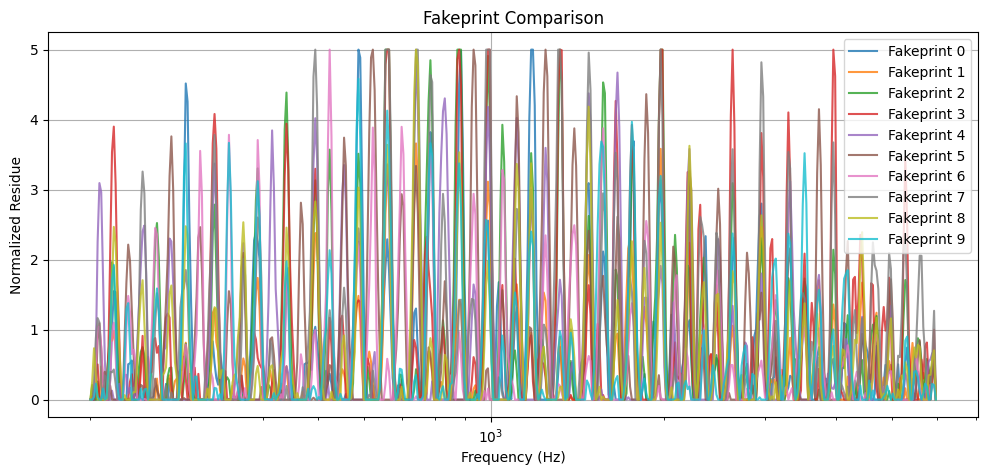

In [12]:
import matplotlib.pyplot as plt

N = 10

def plot_fp(freqs, fakeprints, log_scale=True):
    plt.figure(figsize=(12, 5))
    for i, fp in enumerate(fakeprints):
        plt.plot(freqs, fp, label=f"Fakeprint {i}", alpha=0.8)
    if log_scale:
        plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Normalized Residue')
    plt.title('Fakeprint Comparison')
    plt.legend()
    plt.grid()
    plt.show()

plot_fp(freqs, fakeprints[:N], log_scale=True)